### The goal of this notebook is to compare Poliastro propagation results with the software DRAMA (OSCAR)

In [1]:
import sys
from typing import Tuple, Callable

from astropy import units as u
from astropy.time import Time, TimeDelta
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
from datetime import datetime
import numpy as np
from poliastro.bodies import Earth

sys.path.insert(0, "../")
from digital_twin.plotting import plot_1d, find_x_scale, plot_1d_multiple

The EOP file 'finals2000A.all' in /Users/mathildesimoni/src/iers/ is already the latest.
The Leap Second file 'Leap_Second.dat' in /Users/mathildesimoni/src/iers/ is already the latest.


In [2]:
earth_R = Earth.R.to(u.km)  # Earth's radius (km)

## 1. Extract data from DRAMA

In [3]:
def read_orbital_elements(filename):
    with open(filename, "r") as file:
        lines = file.readlines()
    # print(lines)

    # Look for the start of the orbital elements table
    for i, line in enumerate(lines):
        if "Title  : Orbital evolution" in line:
            data_start = i + 6

    length = len(lines[data_start:])

    data_time = []
    data_orbital_elements = np.zeros((length, 7))
    for i, line in enumerate(lines[data_start:]):
        line = line.strip("\n ").split()
        data_time.append(" ".join([line[0], line[1]]))
        # print(data_time[-1])
        data_orbital_elements[i] = line[2:]
        # print(data_orbital_elements[i])

    return data_time, data_orbital_elements


def read_solar_activity(filename):
    with open(filename, "r") as file:
        lines = file.readlines()
    # print(lines)

    # Look for the start of the orbital elements table
    for i, line in enumerate(lines):
        if "Title  : Solar and geomagnetic activity" in line:
            data_start = i + 10
    length = len(lines[data_start:])

    data_time = []
    data_solar_activity = np.zeros((length, 3))

    for i, line in enumerate(lines[data_start:]):
        line = line.strip("\n ").split()
        data_time.append(line[0])
        data_solar_activity[i] = line[1:]

    return data_time, data_solar_activity

In [4]:
# # first sim: constant solar activity
# type_sim = "500km_sa_cst"
# subfolder = "logs_500km_sa_cst/"
# filename_orbital_elements = "CHESS_decay_v5.oev"
# filename_solar_activity = "CHESS_decay_v5.osg"

# # second sim: varying solar activity
# type_sim = "500km_sa_not_cst"
# subfolder = "logs_500km_sa_not_cst/"
# filename_orbital_elements = "CHESS_decay_v4.oev"
# filename_solar_activity = "CHESS_decay_v4.osg"

# varying solar activity with correct inclination value
type_sim = "500km_sa_not_cst_2"
subfolder = "logs_500km_sa_not_cst_2/"
filename_orbital_elements = "CHESS_decay_v7.oev"
filename_solar_activity = "CHESS_decay_v7.osg"

folder = "logs_DRAMA/"
path_orbital_elements = folder + subfolder + filename_orbital_elements
path_solar_activity = folder + subfolder + filename_solar_activity
save_folder = "DRAMA_results/"

In [5]:
# Orbital elements
times, orbital_elements = read_orbital_elements(path_orbital_elements)
# print("Orbital Elements Table:\n", orbital_elements)
times = np.array(
    [Time(string_date, format="iso", scale="utc") for string_date in times]
)
initial_time = times[0]
final_time = times[-1]
tofs = np.array(
    [TimeDelta(time - initial_time).sec for time in times]
)  # Outputs in seconds
duration_sim = TimeDelta(final_time - initial_time)
altitudes = orbital_elements[:, 1] - earth_R.value

# Solar activity
times_sa, solar_activity = read_solar_activity(path_solar_activity)
times_sa_string = times_sa
# print("Solar Activity Table:\n", solar_activity)
times_sa = np.array(
    [Time.strptime(string_date, "%d/%m/%Y") for string_date in times_sa]
)
initial_time_sa = times_sa[0]
final_time_sa = times_sa[-1]
tofs_sa = np.array(
    [TimeDelta(time_sa - initial_time_sa).sec for time_sa in times_sa]
)  # Outputs in seconds
duration_sa = TimeDelta(final_time_sa - initial_time_sa)
F10 = solar_activity[:, 0]
Ap = solar_activity[:, 2]

/Users/mathildesimoni/anaconda3/envs/digital_twin_env/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/mathildesimoni/anaconda3/envs/digital_twin_env/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


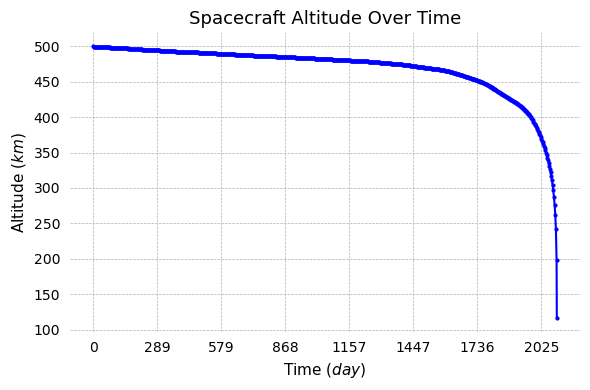

In [6]:
# plot altitude
x_label, x_label_f = find_x_scale(duration_sim)
step = 1

plot_1d(
    tofs,
    altitudes,
    "Spacecraft Altitude Over Time",
    x_label,
    r"Altitude ($km$)",
    step=step,
    fill_under=False,
    remove_box=True,
    y_range=(min(altitudes) - 20, max(altitudes) + 20),
    x_label_f=x_label_f,
    show=True,
    save_filename=save_folder + type_sim + "_altitude.jpg",
)

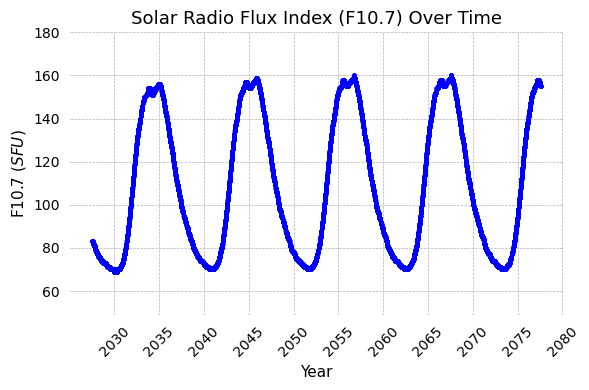

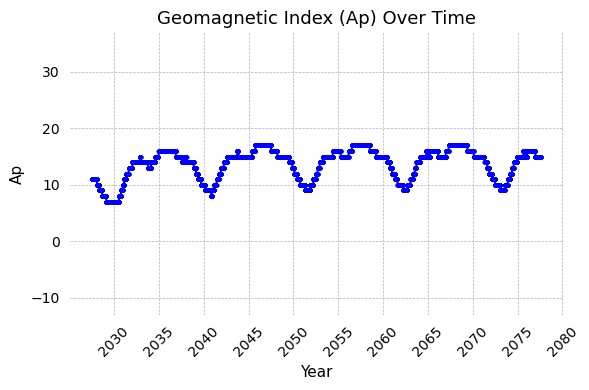

In [7]:
# plot solar activity
x_label = "Year"
step = 1

plot_1d(
    [datetime.strptime(date, "%d/%m/%Y") for date in times_sa_string],
    F10,
    "Solar Radio Flux Index (F10.7) Over Time",
    x_label,
    r"F10.7 ($SFU$)",
    step=step,
    fill_under=False,
    remove_box=True,
    y_range=(min(F10) - 20, max(F10) + 20),
    show=True,
    save_filename=save_folder + type_sim + "_F10.jpg",
    date_x_axis=True,
    date_interval=365 * 5,
    date_format="%Y",
)

plot_1d(
    [datetime.strptime(date, "%d/%m/%Y") for date in times_sa_string],
    Ap,
    "Geomagnetic Index (Ap) Over Time",
    x_label,
    r"Ap",
    step=step,
    fill_under=False,
    remove_box=True,
    y_range=(min(Ap) - 20, max(Ap) + 20),
    show=True,
    save_filename=save_folder + type_sim + "_Ap.jpg",
    date_x_axis=True,
    date_interval=365 * 5,
    date_format="%Y",
)

In [8]:
# save the data in numpy arrays
with open(save_folder + type_sim + "_times.npy", "wb") as f:
    np.save(f, tofs)
with open(save_folder + type_sim + "_altitudes.npy", "wb") as f:
    np.save(f, altitudes)
with open(save_folder + type_sim + "_times_sa.npy", "wb") as f:
    np.save(f, tofs_sa)
with open(save_folder + type_sim + "_dates_sa.npy", "wb") as f:
    np.save(f, times_sa)
with open(save_folder + type_sim + "_F10.npy", "wb") as f:
    np.save(f, F10)
with open(save_folder + type_sim + "_Ap.npy", "wb") as f:
    np.save(f, Ap)

## 2. Compare with results from the propagator

In [11]:
# DRAMA data
times_DRAMA = np.load(save_folder + type_sim + "_times.npy")
altitudes_DRAMA = np.load(save_folder + type_sim + "_altitudes.npy")

# Poliastro propagator data
results_folder = "../../results/"
times = np.load(results_folder + "times.npy")
altitudes = np.load(results_folder + "altitude.npy")

176083200.0
181012553.0
176083200.0


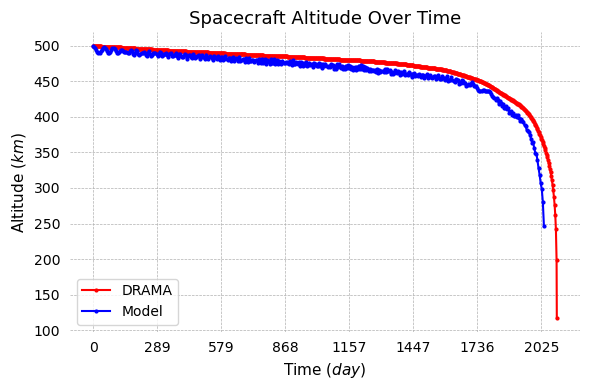

In [14]:
duration_sim_DRAMA = TimeDelta(times_DRAMA[-1])
duration_sim = TimeDelta(times[-1])
print(duration_sim)
duration = max(duration_sim, duration_sim_DRAMA)
x_label, x_label_f = find_x_scale(duration)

steps = [1, 700]
labels = ["DRAMA", "Model"]
colors = ["red", "blue"]
xs = [times_DRAMA, times]
ys = [altitudes_DRAMA, altitudes]

print(times_DRAMA[-1])
print(times[-1])

plot_1d_multiple(
    xs,
    ys,
    "Spacecraft Altitude Over Time",
    x_label,
    r"Altitude ($km$)",
    colors=colors,
    labels=labels,
    step=steps,
    fill_under=False,
    remove_box=True,
    show=True,
    x_label_f=x_label_f,
    save_filename=save_folder + type_sim + "_lifetime_comparison.jpg",
)

In [ ]:
# plt.figure()
# plt.title(r"Lifetime Analysis")
# plt.plot(times_DRAMA, altitudes_DRAMA, label="DRAMA")
# plt.plot(times, altitudes, label="New Model")
# plt.legend()
# plt.ylabel(r"Altitude (km)")
# plt.xlabel(r"Time (sec)")
# plt.grid()
# plt.show()